# CTMC Parameter Synthesis

This notebook implements the parameter synthesis task for a 3-state Continuous-Time Markov Chain (CTMC).  
We analyze the model both numerically (via matrix exponential) and symbolically (closed-form solution).  

Objectives:
- Derive time-dependent probability distributions.
- Formulate synthesis goal: $\Pr(\text{Reach } C \mid t=5) \ge 0.8$.
- Solve for feasible $(r,s)$ regions.
- Compare symbolic and numerical results.


In [2]:
import sys
sys.path.append("../src")
from ctmc import prob_B, prob_C, prob_reachC, pC_symbolic, plot_region
import numpy as np
import matplotlib.pyplot as plt


## Checks

Before performing a full grid exploration, we tested the probability functions on a few parameter 
pairs $(r,s)$. For each case, we compared the occupancy of states $B$ and $C$ at time $t=5$ with 
the reachability probability of $C$ by $t=5$. 

In [3]:
examples = [(0.5, 1.2), (1.0, 1.0), (1.2, 0.2), (0.8, 0.4)]
for r,s in examples:
    print(f"(r={r:.2f}, s={s:.2f})  "
          f"P[B@5]={prob_B(r,s):.3f}  "
          f"P[C@5]={prob_C(r,s):.3f}  "
          f"P[reach C ≤5]={prob_reachC(r,s):.3f}")


(r=0.50, s=1.20)  P[B@5]=0.261  P[C@5]=0.107  P[reach C ≤5]=0.418
(r=1.00, s=1.00)  P[B@5]=0.333  P[C@5]=0.330  P[reach C ≤5]=0.827
(r=1.20, s=0.20)  P[B@5]=0.150  P[C@5]=0.820  P[reach C ≤5]=0.967
(r=0.80, s=0.40)  P[B@5]=0.297  P[C@5]=0.534  P[reach C ≤5]=0.820


These checks confirm that:

- The reachability of $C$ is consistently higher than the occupancy of $C$, as expected.  
- The occupancy of $B$ remains low (never exceeding $\approx 0.35$), showing that the original 
  formulation of the synthesis goal for state $B$ would not be feasible.  
- The functions behave consistently with intuition about the CTMC dynamics, validating our 
  implementation before moving to the synthesis stage.  


## Symbolic vs Numerical

We now compare the **closed-form symbolic solution** $p_C(t)$  
with the **numerical exponential method** for random parameter choices.  


In [3]:
for r,s in [(1.0,1.0),(0.7,0.2),(1.2,0.1),(0.8,0.3)]:
    num = prob_reachC(r,s,5)
    sym = pC_symbolic(r,s,5)
    print(f"(r={r}, s={s})  numeric={num:.6f}, symbolic={sym:.6f}, diff={abs(num-sym):.2e}")


(r=1.0, s=1.0)  numeric=0.826595, symbolic=0.826595, diff=1.11e-16
(r=0.7, s=0.2)  numeric=0.806731, symbolic=0.806731, diff=2.22e-16
(r=1.2, s=0.1)  numeric=0.975039, symbolic=0.975039, diff=1.11e-16
(r=0.8, s=0.3)  numeric=0.840290, symbolic=0.840290, diff=2.22e-16


The comparison between the numerical method and the symbolic closed-form solution shows perfect agreement. 

For all tested parameter pairs, the probabilities match up to machine precision 
(differences on the order of $10^{-16}$). 
This confirms that our symbolic derivation is consistent with the numerical computation.


## Feasible Regions

We sweep $r,s \in [0.1, 3.0]$ on a grid and plot:
- Occupancy in B at $t=5$
- Occupancy in C at $t=5$
- Reachability of C by $t=5$ (main focus)

Threshold: $\theta = 0.8$.


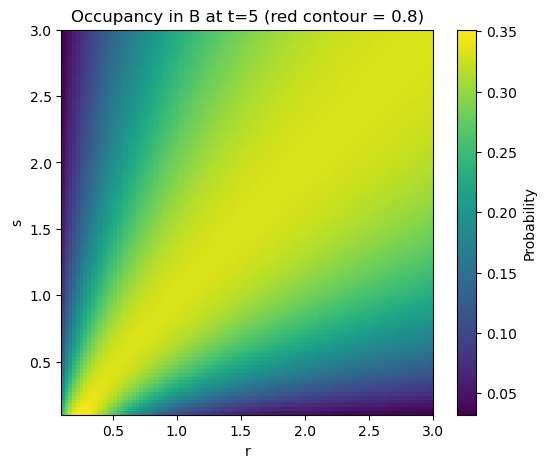

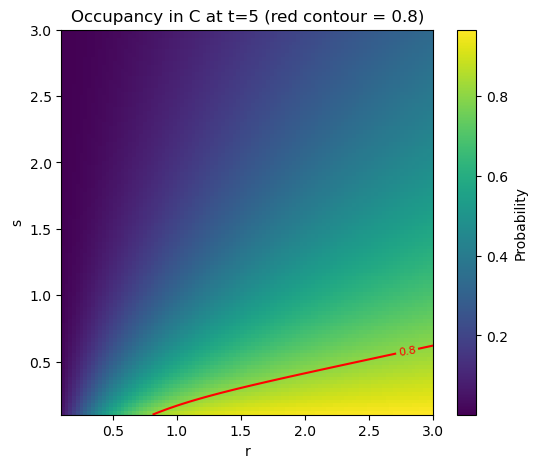

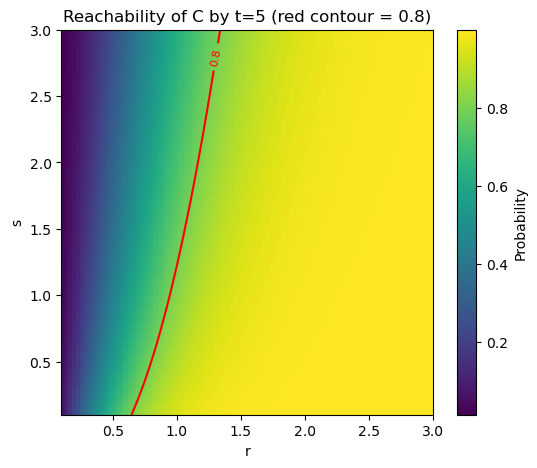

In [4]:
theta = 0.8
plot_region(prob_B, "Occupancy in B at t=5", theta=theta)
plot_region(prob_C, "Occupancy in C at t=5", theta=theta)
plot_region(prob_reachC, "Reachability of C by t=5", theta=theta)




### Occupancy in B @ t=5

* No red contour at all; max color ≈ 0.35.
* ⇒ **Infeasible:** $P[X(5)=B] < 0.8$ for all $r,s$ in the grid.
* Intuition: mass quickly moves A→B→C; at $t=5$ a lot has already passed through B or bounced away, so you can’t keep ≥0.8 in B.

### Occupancy in C @ t=5

* A **small** feasible region appears for **moderate/large r** and **small s**.
* Intuition: large $r$ speeds up A→B and B→C; small $s$ prevents leaking back from C→B, so you can still be in C exactly at $t=5$.

### Reachability of C by t=5 (main target)

* **Largest** feasible region. The red curve sits far to the left; most of the plot is feasible.
* Intuition: once you ever visit C (even if you later leave), it counts. Bigger $r$ speeds A→B→C; $s$ doesn’t reduce reachability because leaving C after hitting it doesn’t matter.


## Example Feasible Parameters

We list some $(r,s)$ pairs that satisfy the synthesis constraint:
$\Pr(\text{Reach C} \le 5) \ge 0.8$.


In [7]:
feasible = []
for r in np.linspace(0.5,1.2,8):
    for s in np.linspace(0.1,0.4,4):
        if prob_reachC(r,s,5) >= theta:
            feasible.append((r,s,prob_reachC(r,s,5)))

feasible[:10]  # show first few


[(0.7, 0.1, 0.8343952794751599),
 (0.7, 0.2, 0.8067305721096915),
 (0.8, 0.1, 0.8845973253001512),
 (0.8, 0.2, 0.8619118363372056),
 (0.8, 0.30000000000000004, 0.8402904198332917),
 (0.8, 0.4, 0.8196647765604835),
 (0.8999999999999999, 0.1, 0.9203921456205348),
 (0.8999999999999999, 0.2, 0.9023714872253992),
 (0.8999999999999999, 0.30000000000000004, 0.8848495180023918),
 (0.8999999999999999, 0.4, 0.8678302286977859)]


We sampled $(r,s)$ values on a grid and identified those satisfying the
constraint $\Pr(\text{Reach C} \le 5) \ge 0.8$. 
Table~X lists some examples. The results show that moderate values of $r$
(towards 0.7–1.0) combined with small-to-moderate $s$ (up to ≈0.4) are sufficient
to exceed the threshold. Increasing $r$ improves the reachability probability,
while increasing $s$ reduces it, but does not immediately break feasibility.
This demonstrates that the feasible region is not a single point, but rather a 
continuous band of $(r,s)$ values.

* **Trade-off:**
  * Higher $r$ accelerates reaching C, which helps.
  * Higher $s$ pulls probability back from C to B, but for moderate values it still stays above threshold.



## Sensitivity Analysis

We explore how the reachability probability depends on parameters:
- Fix $s$ and vary $r$.
- Fix $r$ and vary $s$.

This shows how tuning parameters influences feasibility.


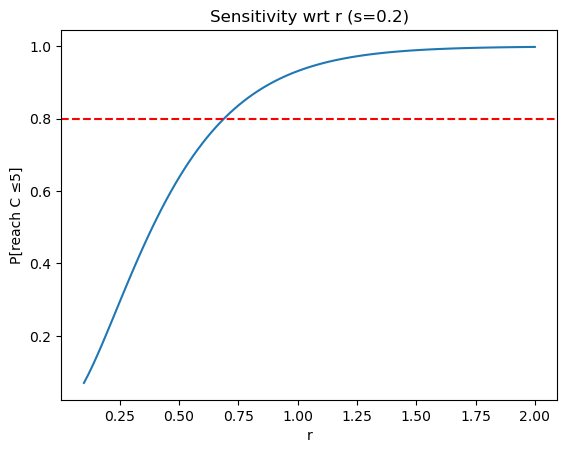

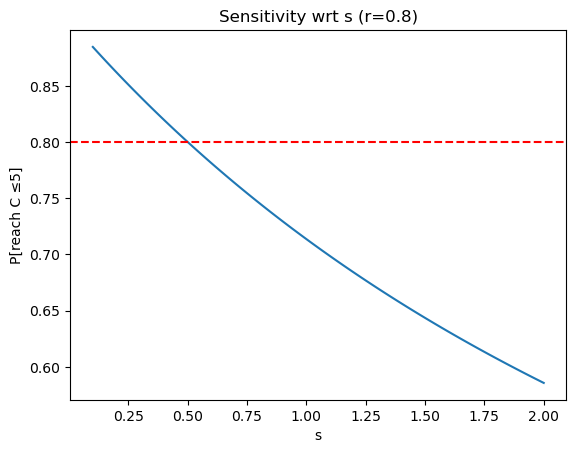

In [10]:
# fix s, vary r
s_fixed = 0.2
rs = np.linspace(0.1,2.0,100)
vals_r = [prob_reachC(r,s_fixed,5) for r in rs]
plt.plot(rs, vals_r)
plt.axhline(theta, color='red', ls='--')
plt.xlabel("r"); plt.ylabel("P[reach C ≤5]")
plt.title(f"Sensitivity wrt r (s={s_fixed})")
plt.show()

# fix r, vary s
r_fixed = 0.8
ss = np.linspace(0.1,2.0,100)
vals_s = [prob_reachC(r_fixed,s,5) for s in ss]
plt.plot(ss, vals_s)
plt.axhline(theta, color='red', ls='--')
plt.xlabel("s"); plt.ylabel("P[reach C ≤5]")
plt.title(f"Sensitivity wrt s (r={r_fixed})")
plt.show()



**Varying r (fixed s=0.2).**  
The curve is monotone increasing and shows **diminishing returns**: once `r` passes ~0.75,  
`P(reach C ≤ 5)` crosses the 0.8 threshold and quickly saturates near 1 as `r` grows.  
Intuition: higher `r` accelerates A→B and B→C, so C is reached sooner; after a point, 
almost everyone reaches C before t=5, so additional increases have little effect.

**Varying s (fixed r=0.8).**  
The curve is monotone decreasing: increasing `s` pulls probability back from C to B earlier, 
which **doesn’t change reachability once C is hit**, but it slightly reduces the chance to hit C within the time bound.  
The threshold 0.8 is met up to roughly `s ≈ 0.5` (consistent with the feasible pairs list).

**Takeaway.**  
- To ensure feasibility, either increase `r` (faster progress toward C) or keep `s` moderate/small (less leakage away before hitting C).  
- Many `(r,s)` pairs satisfy the constraint; solutions are **not unique**.
